# Notebook to generate all plots on Surya's MSc Thesis

In [1]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

import pickle
from sklearn.decomposition import PCA

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Unsupervised learning phase plots

### Loading avdsr model with default init

In [2]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=(), config=0) #CHECK
#     config.network_fn = lambda: SRNetCNN(config.action_dim, SRIdentityBody(config.state_dim), 
#                                          hidden_units=(2000,), config=0)
    config.replay_fn = lambda: Replay(memory_size=int(4e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e1
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    return agent
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [3]:
avdsr = avdsr_feature(game='FourRoomsMatrixNoTerm', agents=[], choice=0)

### Updating weights of avdsr from saved files

In [22]:
# eps = 1
loss_file = '../storage/01-loss.p'
weights_file = '../storage/01-avdsr.weights'
# eps = 0.9
# loss_file = '../storage/02-loss.p'
# weights_file = '../storage/02-avdsr.weights'

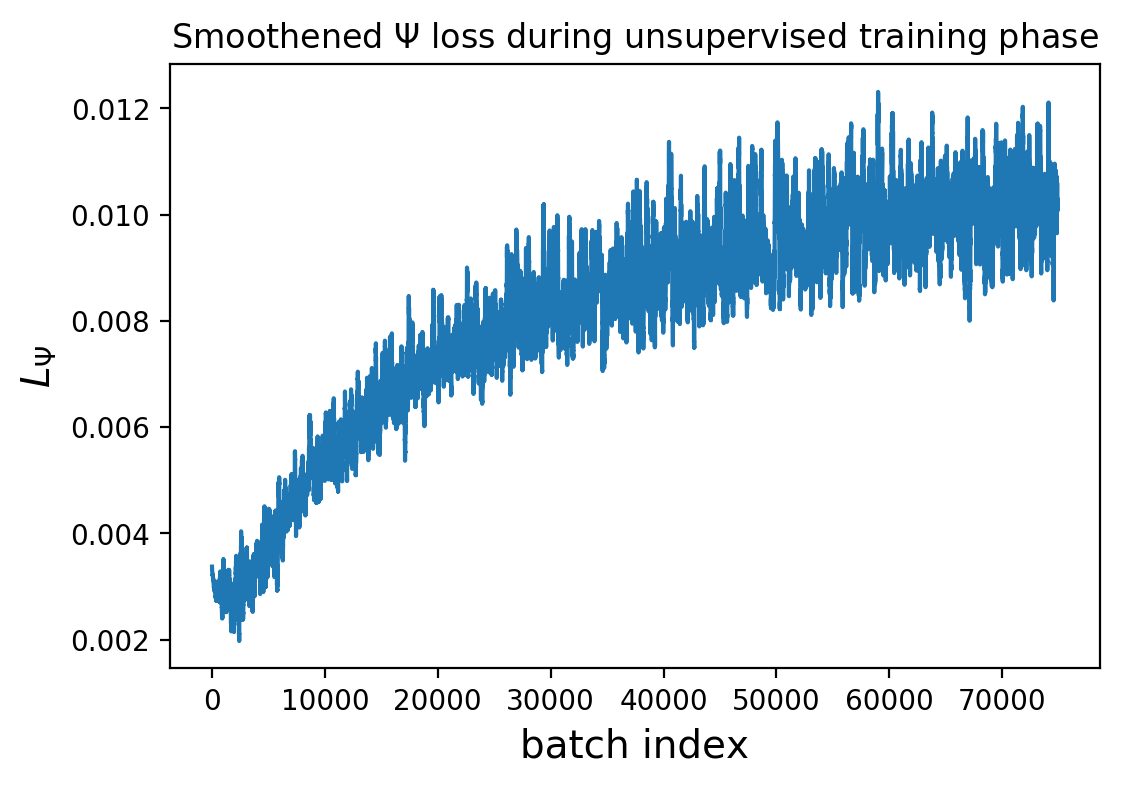

In [23]:
loss = pickle.load(open(loss_file,'rb'))
plt.figure(figsize=(6,4),dpi=200)
plt.plot(convolve(loss,100))
plt.xlabel('batch index',fontsize=14), plt.ylabel('$L_\Psi$',fontsize=14)
plt.title('Smoothened $\Psi$ loss during unsupervised training phase')
plt.show()

In [24]:
weights = torch.load(weights_file, map_location='cpu').state_dict()
avdsr.network.load_state_dict(weights,strict=True)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Text(0.5,1,'Principal components of SFs using PCA')

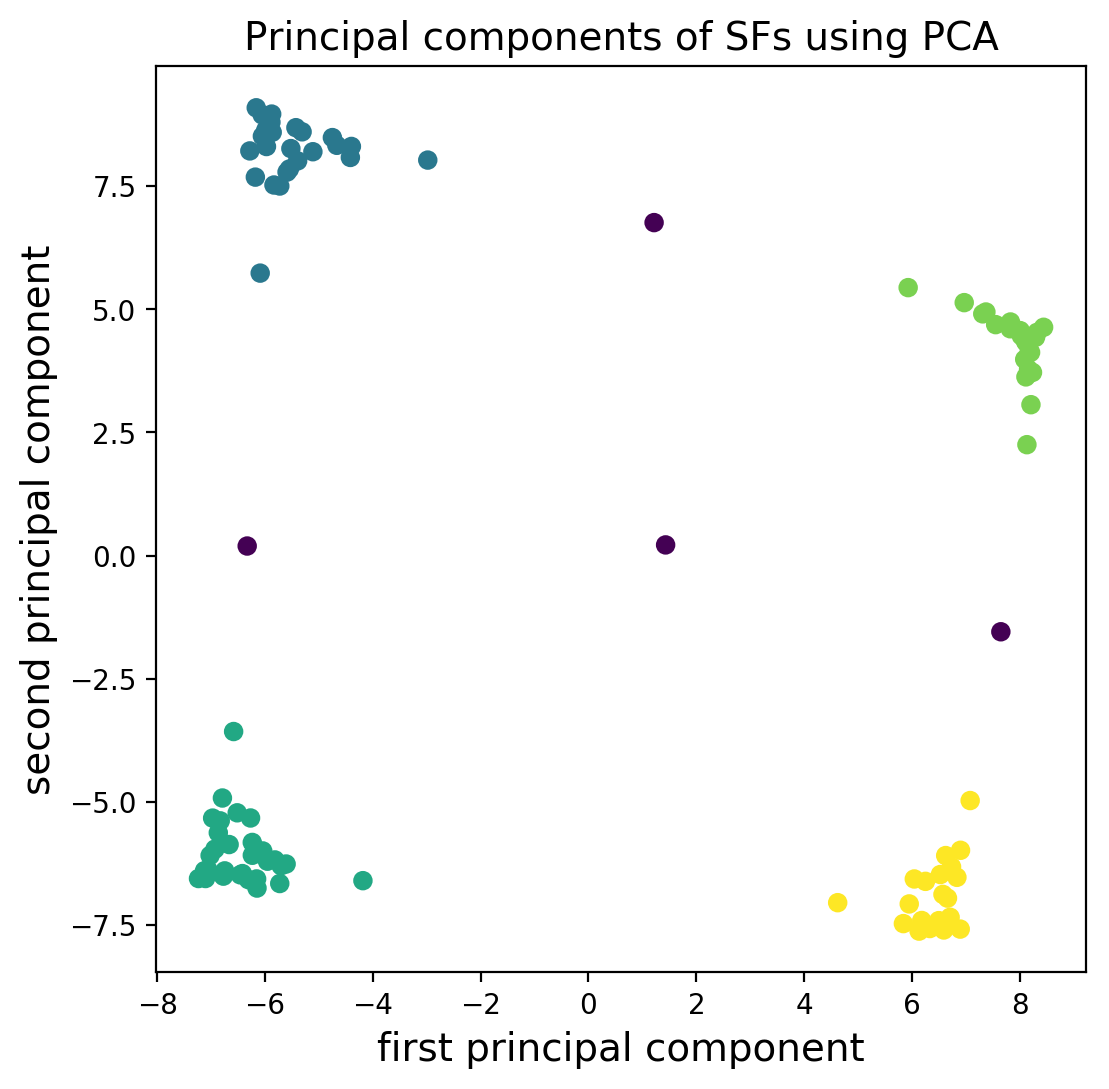

In [25]:
from deep_rl.component.fourrooms import *
g = [21, 28, 84, 91]
c = np.ones(104)*4
room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
connect = [25, 51, 62, 88]
c[room1] = 1
c[room2] = 2
c[room3] = 3
c[connect] = [-1, -1, -1, -1]
env = FourRoomsMatrix(layout='4rooms')
psi_all = np.zeros((104,169*4))
for i in range(104):
    state = env.reset(init=i)
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()
    

plt.figure(figsize=(6,6),dpi=200)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principal component', fontsize=14)
plt.ylabel('second principal component', fontsize=14)
# plt.colorbar()
plt.title('Principal components of SFs using PCA', fontsize=14)

### Visualizing the learnt SRs

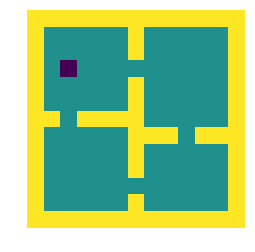

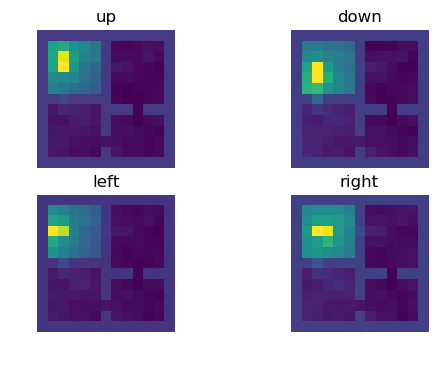

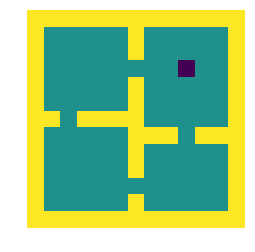

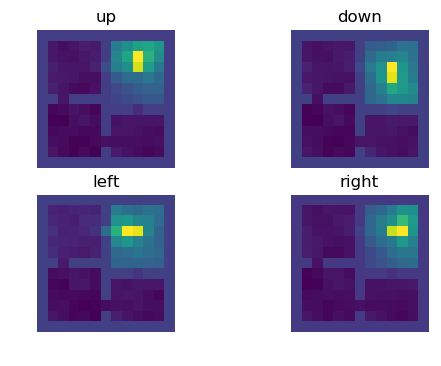

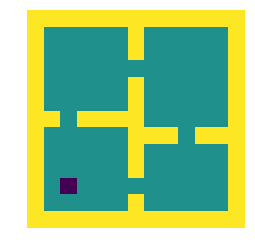

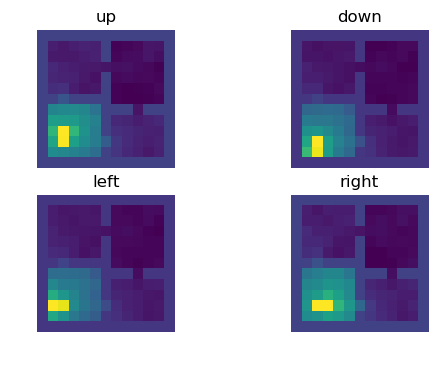

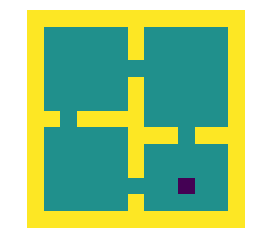

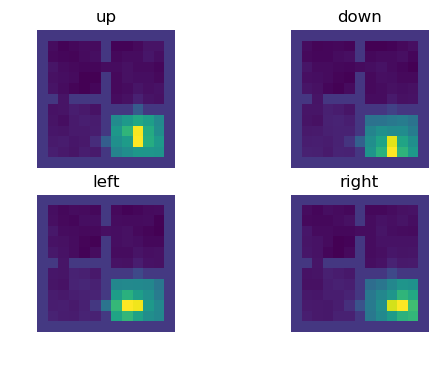

In [26]:
from deep_rl.component.fourrooms import *

g = [21, 28, 84, 91]
dirs = {0: 'up', 1: 'down', 2:'left', 3:'right'}
for i in range(len(g)):
    env = FourRoomsMatrix(layout='4rooms')
    state = env.reset(init=g[i])
    plt.imshow(env.render(show_goal=False))
    plt.axis('off')
    plt.show()
    
    _, out, _ = avdsr.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    
    plt.figure(dpi=100)
    for i in range(4):
        psi_a = psi[0,i,:]
        plt.subplot(2,2,i+1)
        plt.imshow(psi_a.reshape((13,13)))
        plt.title(dirs[i])
        plt.axis('off')
    plt.show()

## Visualize DQN plots

In [9]:
with open('../storage/31-dqn-baselines.p', 'rb') as f:
    rewards = pickle.load(f)
with open('../storage/32-dqn-baselines.p', 'rb') as f:
    rewards2 = pickle.load(f)

In [10]:
rewards.keys()
h_vec = [16, 64, 128, 250, 500, 676, 1000]

In [11]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#ec7603', '#34495e', '#999999']
    
    plt.figure(figsize=(10,5), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
#                 plt.plot(t, r, label=k)
                plt.plot(convolve(np.interp(np.arange(clip), t, r), smooth),label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k+' - '+str(params(h_vec[j]))+' parameters', color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, alpha=0.3, color=colors[j])
    
    plt.xlabel('timesteps', fontsize=14)
    plt.ylabel('episodic returns', fontsize=14)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right'), plt.show()

In [12]:
def params(x):
    return 169*(x)+x + x*(4)+4

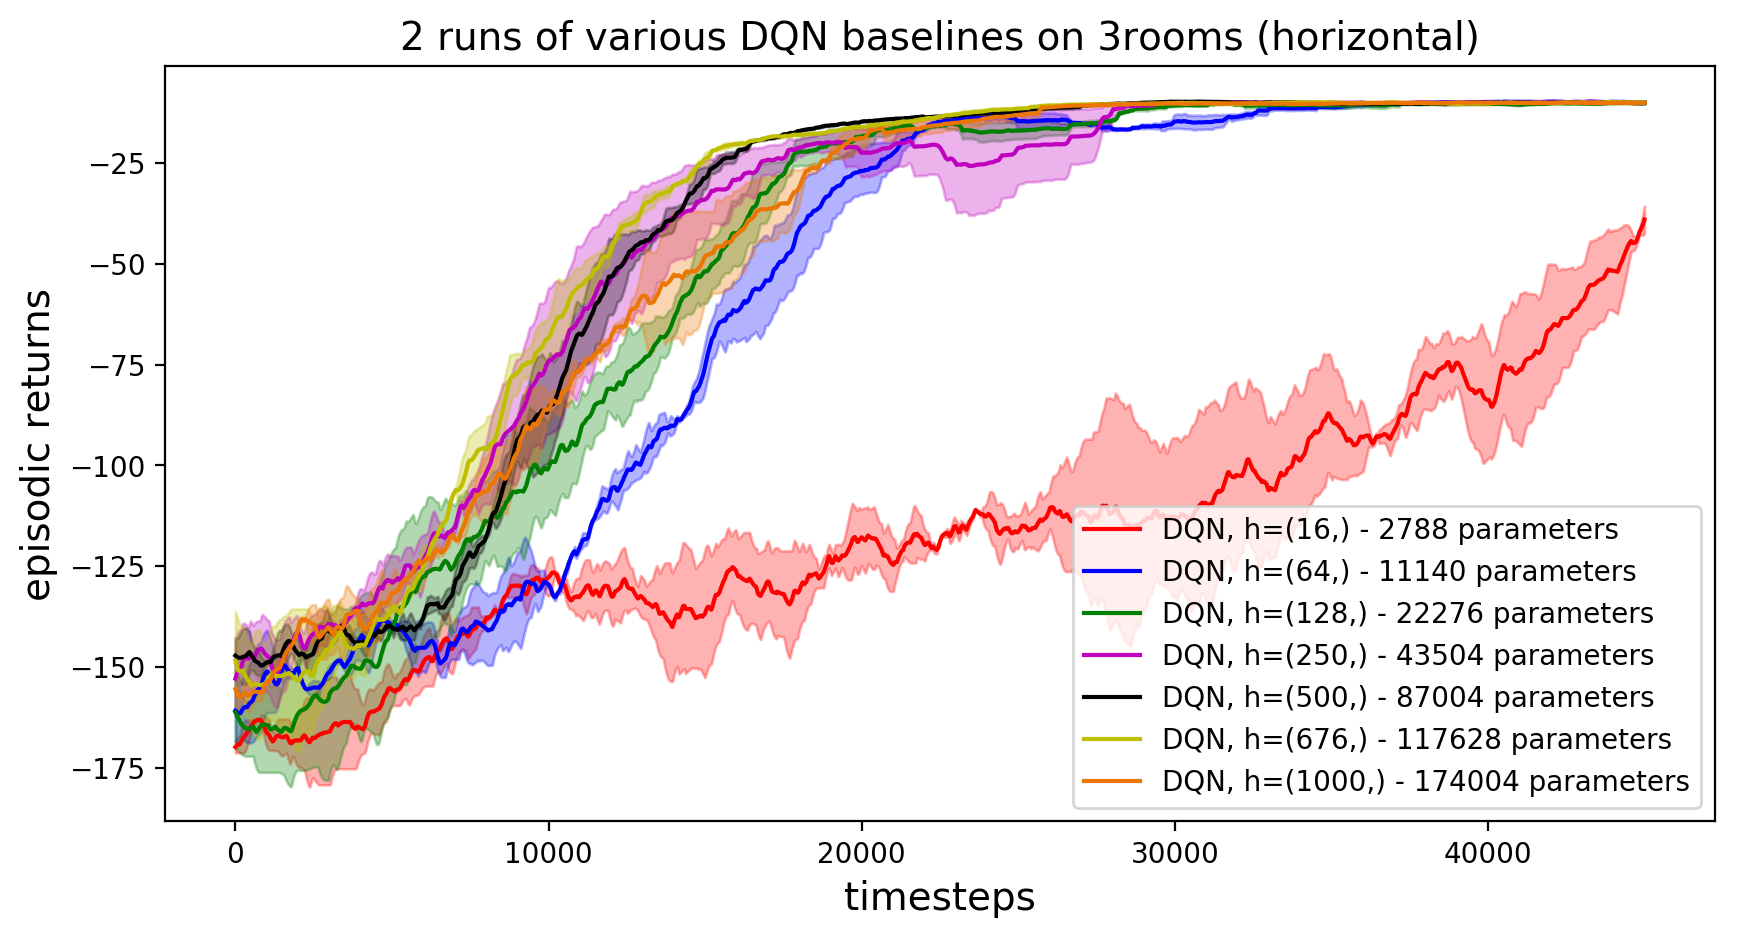

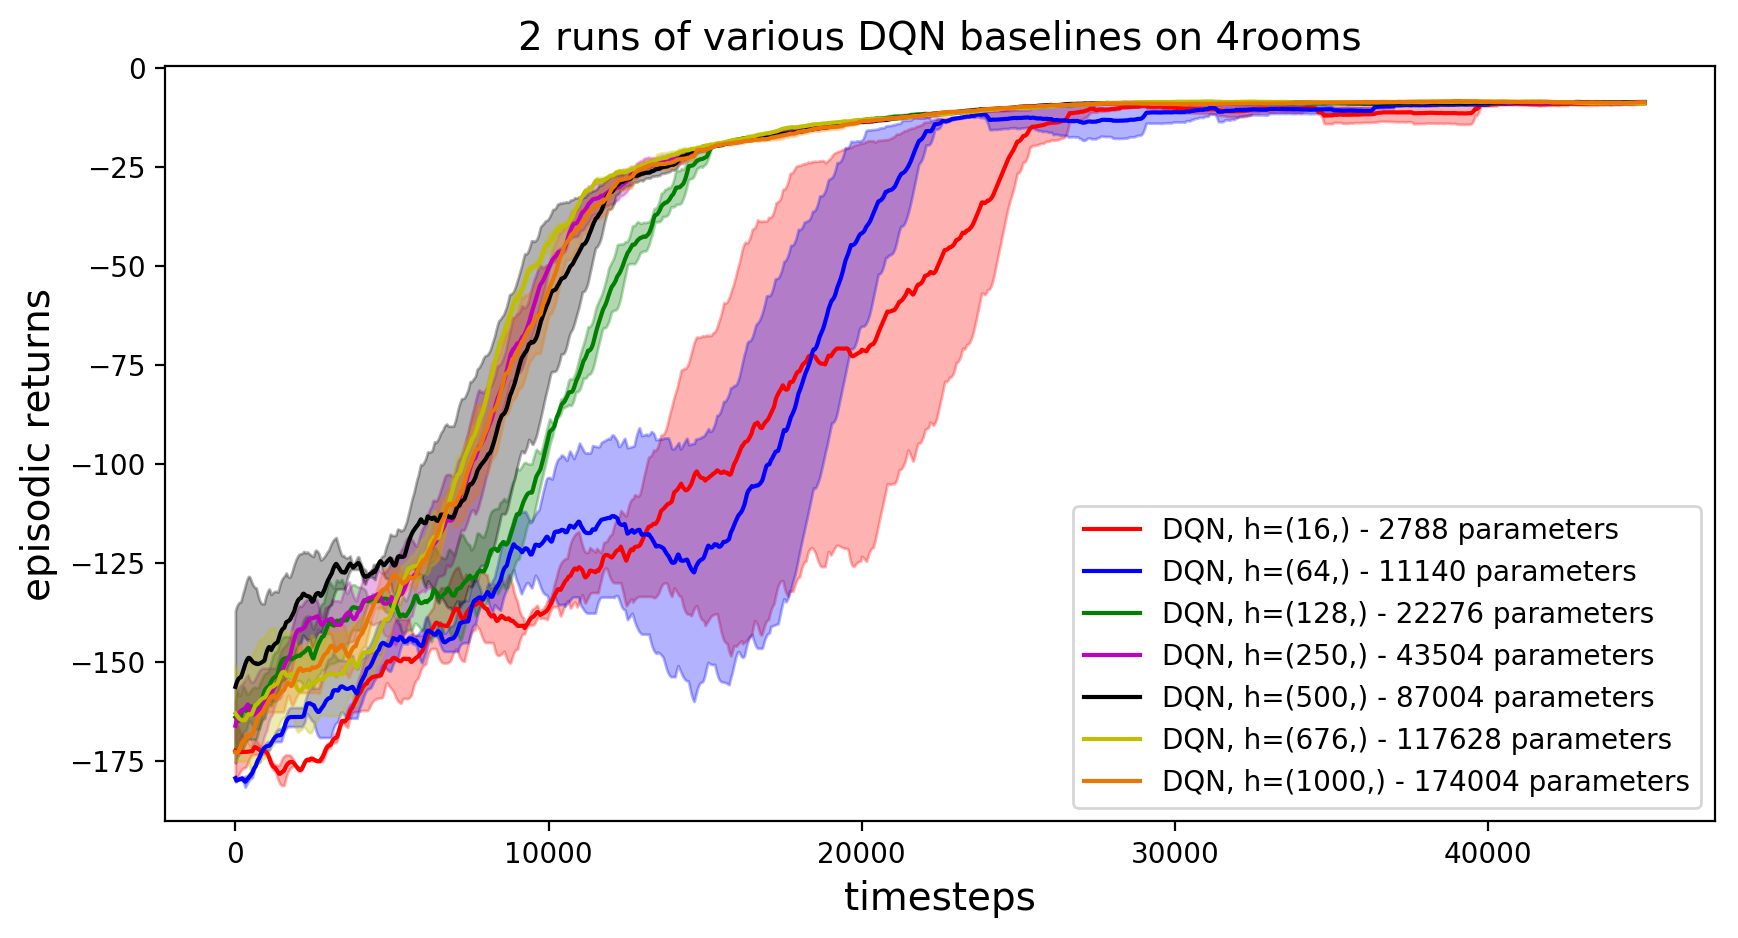

In [13]:
plot_rewards(rewards, plot_seperate=False, 
             title='2 runs of various DQN baselines on 3rooms (horizontal)')
plot_rewards(rewards2, plot_seperate=False, 
             title='2 runs of various DQN baselines on 4rooms')

## Generating plots for the supervised learning phase

### Figure 5.6

In [14]:
rewards = pickle.load(open('../storage/5b-main-generalization-all-baselines.p', 'rb'))
rewards2 = pickle.load( open( "../storage/9-plots.p", "rb" ) )

rewards_con1 = {'DQN h=(16,)- 2788 params': rewards['baseline: DQN, h=(16,): 2788 learnable params'],
               'DQN h=(676,) - 117628 params': rewards2['DQN no shuffle layer 1 weights, fine tuning 0 init fc layer'],
               'DQN h=(676,) - 2708 params': rewards2['DQN shuffled layer 1 weights, fine tuning 0 init fc layer'],
              'MPSF($\pi_{\epsilon=1}$) - 169 params': rewards['avDSR, 1eps: 169 learnable params (3e5 training)'],
              'MPSF($\pi_{\epsilon=1}$) - 2708 params': rewards['avDSR, 1eps: 2708 learnable params (23e5 training)'],
              'MPSF($\pi_{good}$) - 169 params': rewards['avDSR, 0.8eps, 4DQNs: 169 learnable params (3e5 training)'],
              'MPSF($\pi_{good}$) - 2708 params': rewards['avDSR, 0.8eps, 4DQNs: 2708 learnable params (3e5 training)'],}

In [17]:
rewards_con2 = pickle.load( open( '../storage/34-rewards-3roomsh.pickle', "rb" ) )

rewards_con2 = {'DQN h=(16,)- 2788 params': rewards_con2['DQN h=(16,) - 2708 parameters'],
               'DQN h=(676,) - 117628 params': rewards_con2['DQN h=(676,) - 117628 parameters'],
               'DQN h=(676,) - 2708 params': rewards_con2['DQN h=(676,) - 2708 parameters'],
              'MPSF($\pi_{\epsilon=1}$) - 169 params': rewards_con2['AVSF($\\pi_{\\epsilon=1}$) - 169 parameters'],
              'MPSF($\pi_{\epsilon=1}$) - 2708 params': rewards_con2['AVSF($\\pi_{\\epsilon=1}$) - 2708 parameters'],}

In [18]:
rewards_con3 = pickle.load( open( "../storage/34-rewards-3roomsh-contextind.pickle", "rb" ) )

rewards_con3 = {'DQN h=(16,)- 2788 params': rewards_con3['DQN h=(16,) - 2708 parameters'],
               'DQN h=(676,) - 117628 params': rewards_con3['DQN h=(676,) - 117628 parameters'],
               'DQN h=(676,) - 2708 params': rewards_con3['DQN h=(676,) - 2708 parameters'],
              'MPSF($\pi_{\epsilon=1}$) - 169 params': rewards_con3['AVSF($\\pi_{\\epsilon=1}$) - 169 parameters'],
              'MPSF($\pi_{\epsilon=1}$) - 2708 params': rewards_con3['AVSF($\\pi_{\\epsilon=1}$) - 2708 parameters'],}

In [19]:
rewards = pickle.load( open( "../storage/33-3rooms-baselines.p", "rb" ) )
rewards2 = pickle.load( open( "../storage/28-300000-rewards-1eps.p", "rb" ) )

rewards_con4 = {'DQN h=(16,)- 2788 params': rewards['DQN h=(16,) - 2708 parameters'],
               'DQN h=(676,) - 117628 params': rewards['DQN h=(676,) - 117628 parameters'],
               'DQN h=(676,) - 2708 params': rewards['DQN h=(676,) - 2708 parameters'],
              'MPSF($\pi_{\epsilon=1}$) - 169 params': rewards2['avDSR, 1eps, d0.01: 169 learnable params (300000 training)'],
              'MPSF($\pi_{\epsilon=1}$) - 2708 params': rewards2['avDSR, 1eps, d0.01: 2708 learnable params (300000 training)'],}

In [20]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    smooth = 5000
    
    colors = ['grey', 'grey', 'grey', 'r', 'b', 'g', 'm', '#e377c2', '#ec7603', '#34495e', '#999999']
    
    plt.figure(figsize=(10,5), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
#                 plt.plot(t, r, label=k)
                plt.plot(convolve(np.interp(np.arange(clip), t, r), smooth),label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        if('DQN' in k):
            if('2788' in k):
                style='dashed'
            elif('117' in k):
                style='dotted'
            else:
                style='dashdot'
            alpha = 0.2
        else:
            style='solid'
            alpha = 0.3
        plt.plot(mean, label=k, color=colors[j], linestyle=style)
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, alpha=alpha, color=colors[j])
    
    plt.xlabel('timesteps', fontsize=14)
    plt.ylabel('episodic returns', fontsize=14)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right', prop={'size': 12})
    plt.show()

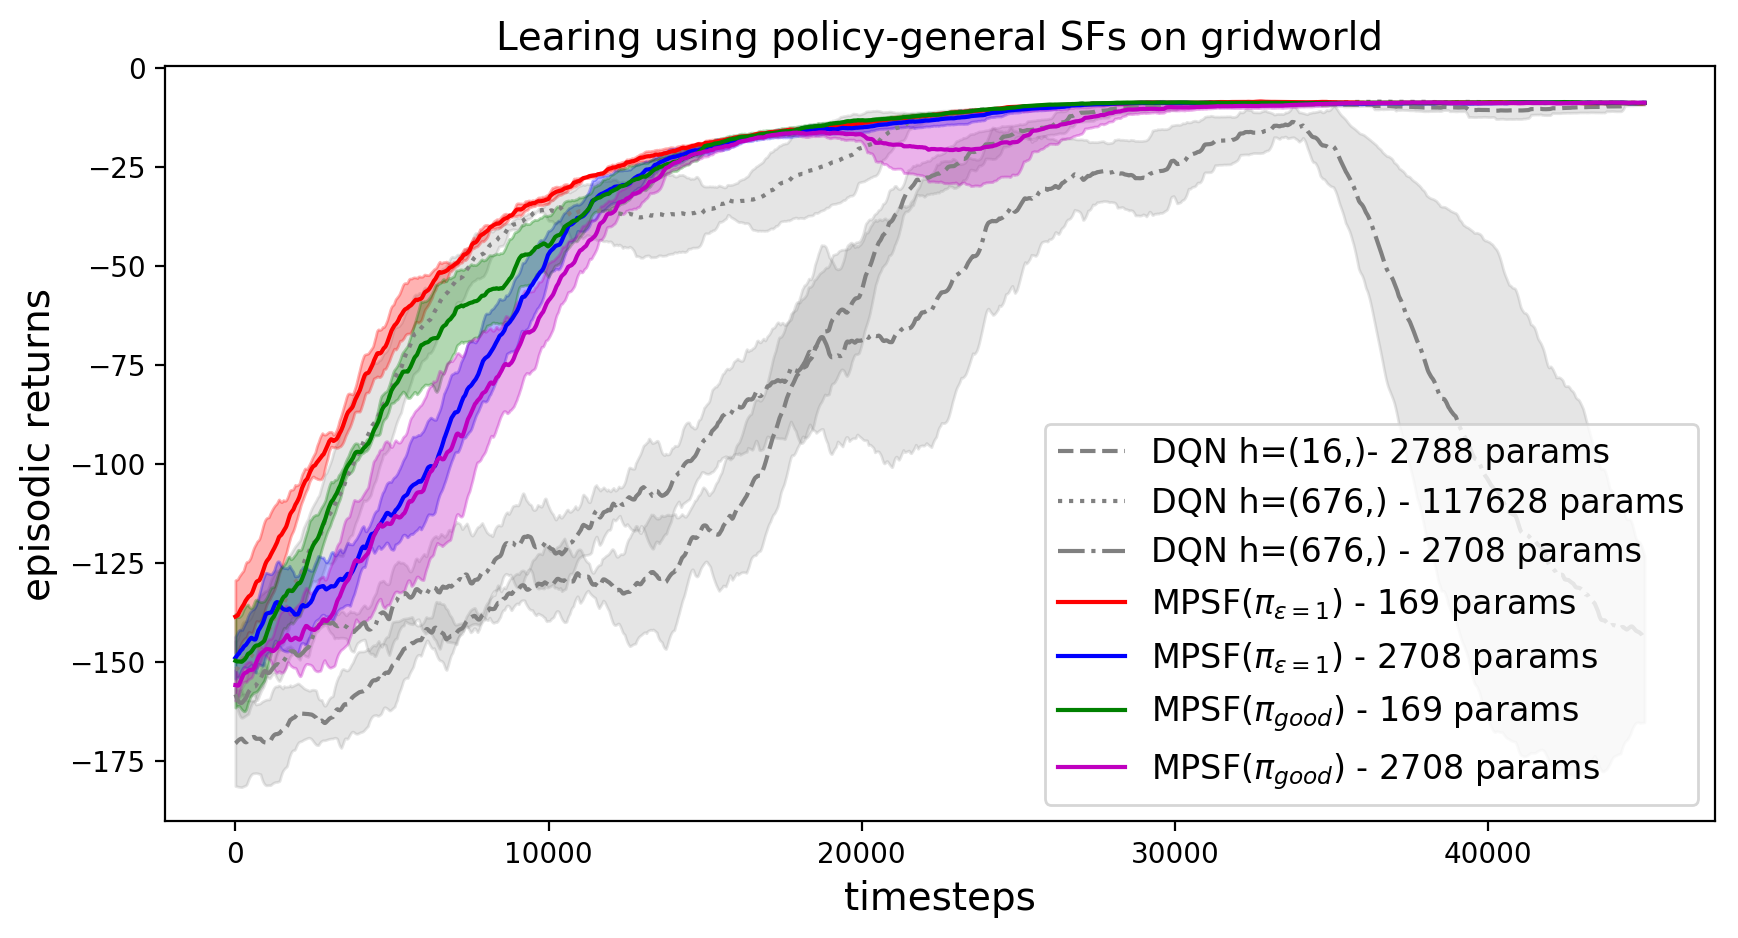

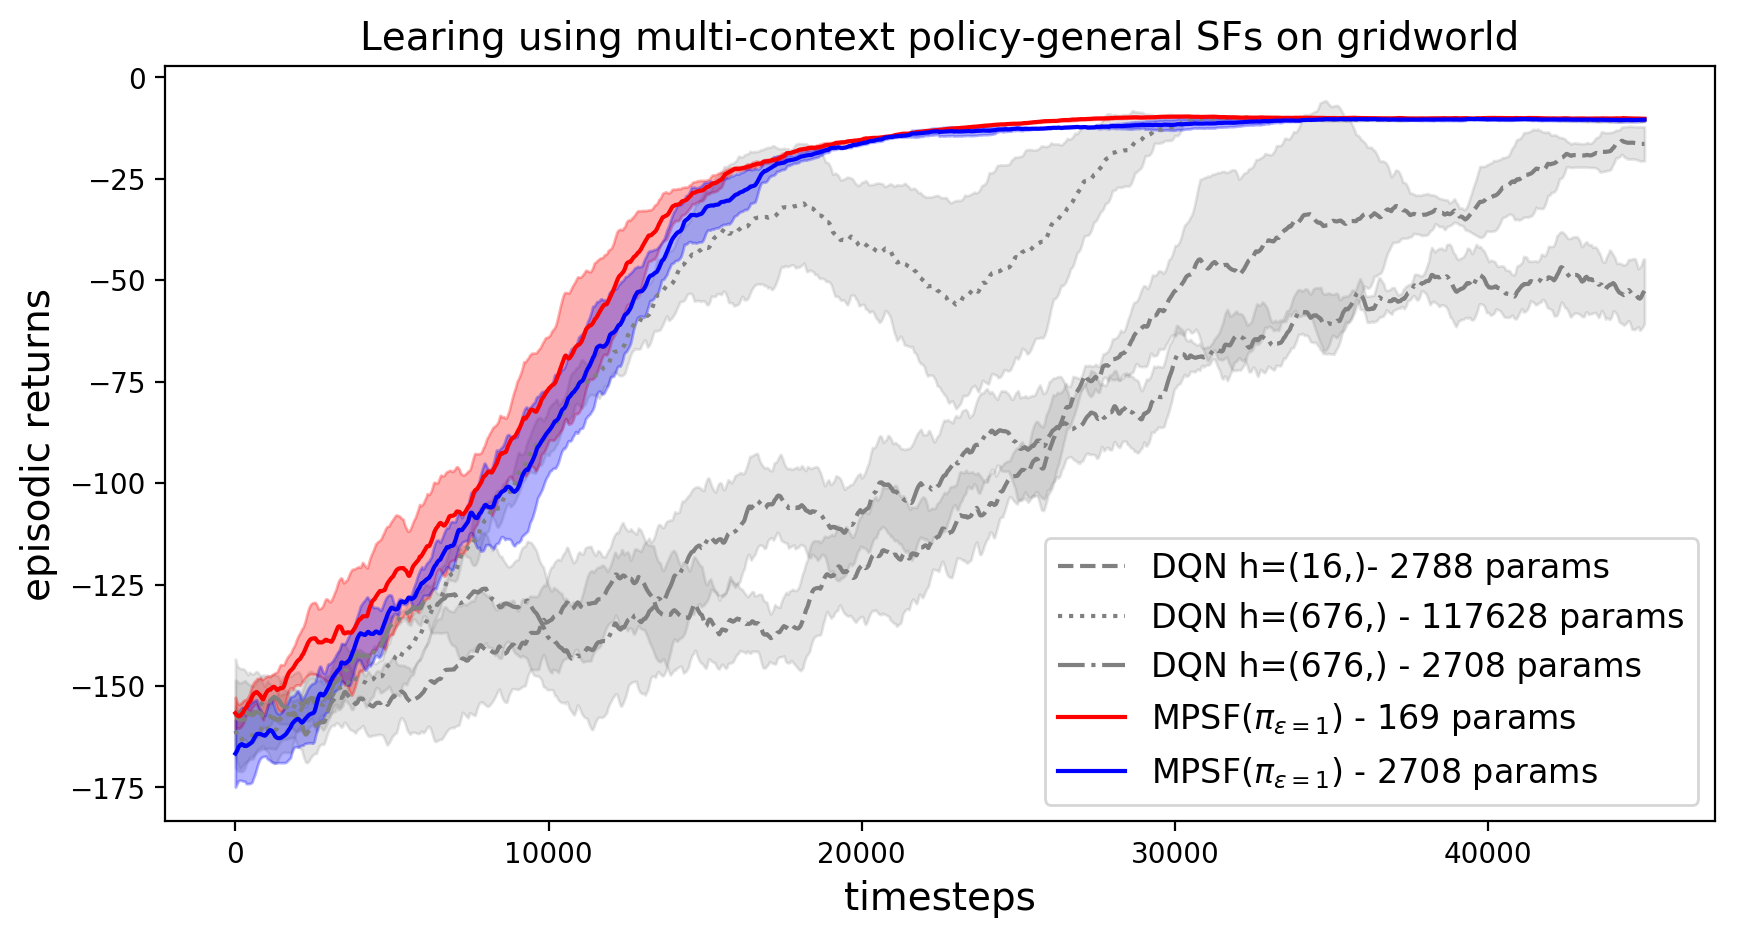

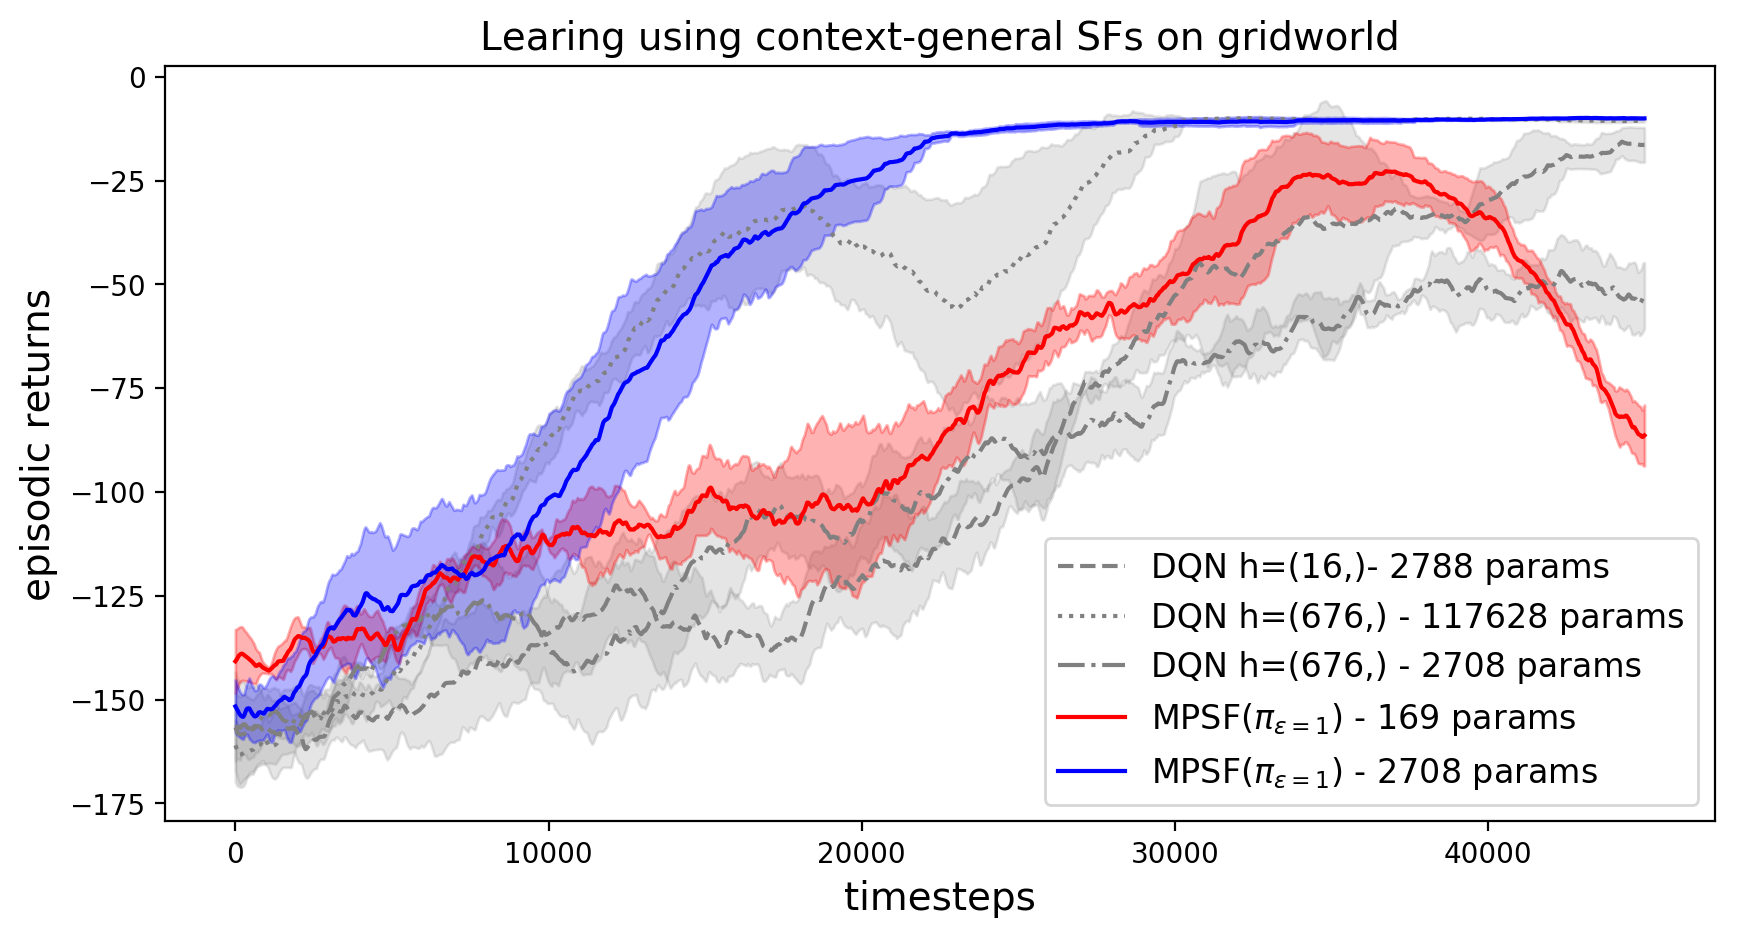

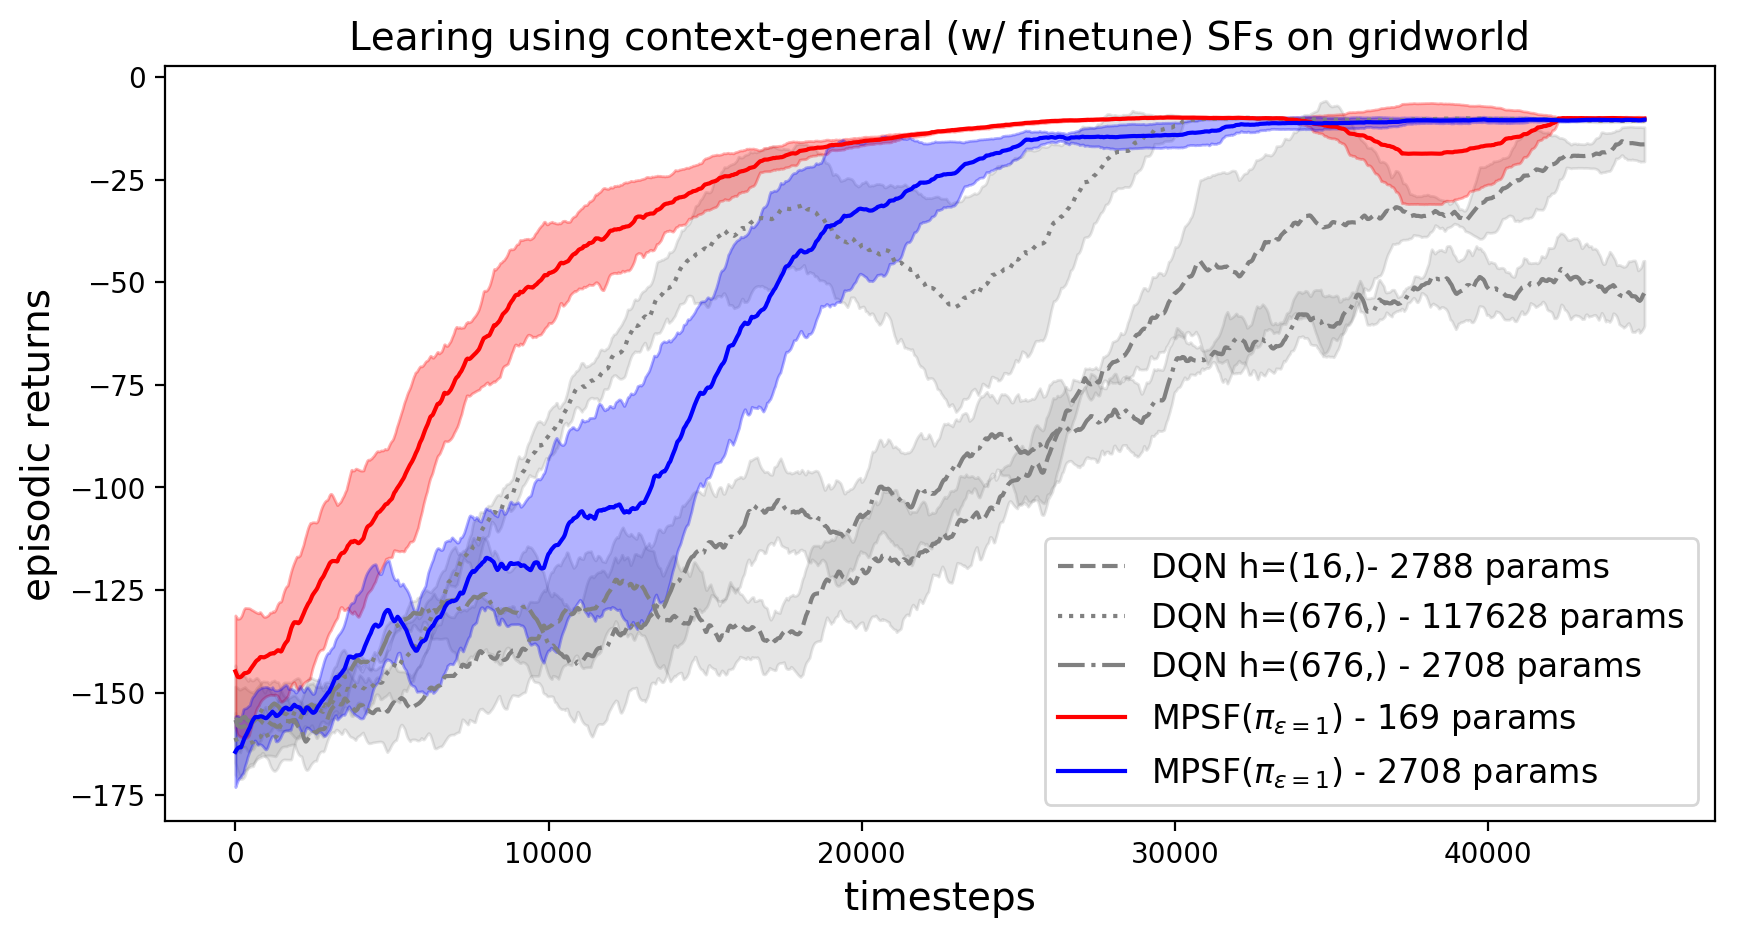

In [21]:
plot_rewards(rewards_con1, plot_seperate=False, 
             title='Learing using policy-general SFs on gridworld')
plot_rewards(rewards_con2, plot_seperate=False, 
             title='Learing using multi-context policy-general SFs on gridworld')
plot_rewards(rewards_con3, plot_seperate=False, 
             title='Learing using context-general SFs on gridworld')
plot_rewards(rewards_con4, plot_seperate=False, 
             title='Learing using context-general (w/ finetune) SFs on gridworld')

## Plotting learning speeds

In [27]:
def plot_performance(file_index='14', title='unnamed'):
    all_rewards = {}
    iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
    # iters = [0]
    for i in iters:
        with open('../storage/'+file_index+'-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
            rewards = pickle.load(f)

            for key, val in rewards.items():
                if('169' in key):
                    all_rewards[str(int(i))+'-169'] = val
                elif('2708' in key):
                    all_rewards[str(int(i))+'-2708'] = val
                else:
                    raise
                    
    plt.figure(figsize=(12,6),dpi=100)
    clip = 50000
    smooth = 1000
    line1 = []
    line1_std = []
    line2 = []
    line2_std = []
    for j, (k, v) in enumerate(all_rewards.items()):
        ind = k.split('-')
        r_vec = np.zeros((len(v[0]), 50000-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

        mean = np.mean(np.array(r_vec), axis=1)
        std = np.std(mean)
        if(ind[1]=='169'):
            line1.append(mean)
            line1_std.append(std)
        if(ind[1]=='2708'):
            line2.append(mean)
            line2_std.append(std)

    line1 = np.array(line1)
    line2 = np.array(line2)
    # import pdb;pdb.set_trace()
    plt.errorbar(iters, np.mean(line1,axis=1), line1_std, label='169 params')
    plt.errorbar(iters, np.mean(line2,axis=1), line2_std,label='2708 params')
    for i in range(line1.shape[1]):
        plt.scatter(iters, line1[:,i], c='b', alpha=0.3)
        plt.scatter(iters, line2[:,i], c='r', alpha=0.3)

    plt.xscale('log')
    plt.xlabel('unsupervised training iterations (log)'), plt.ylabel('average rewards (in 50000 timesteps)')
    plt.title(title)
    plt.legend(), plt.show()

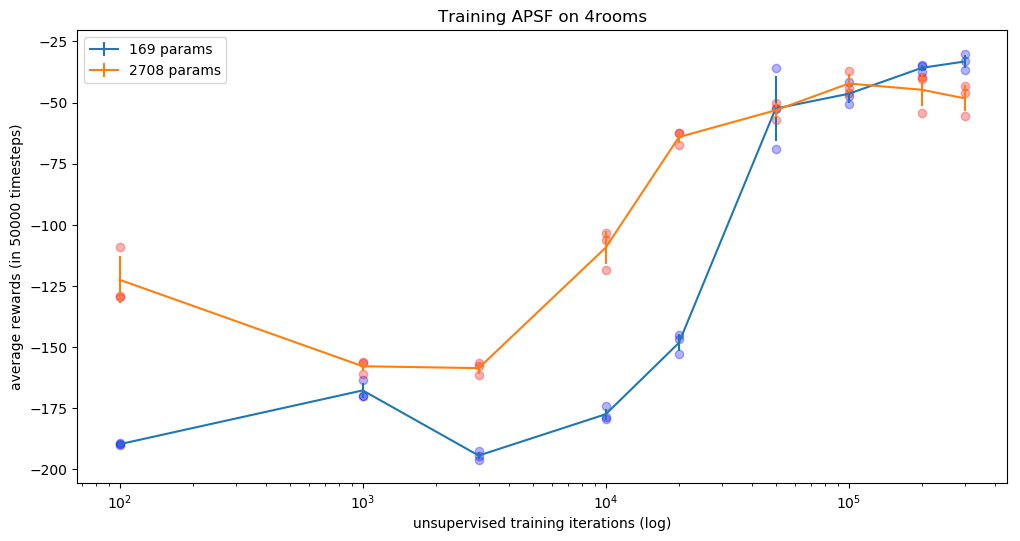

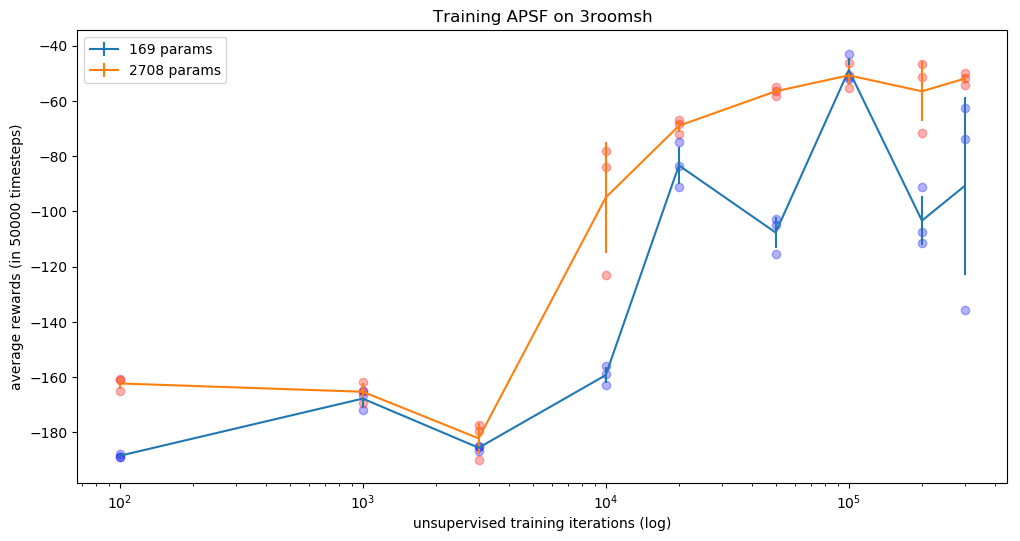

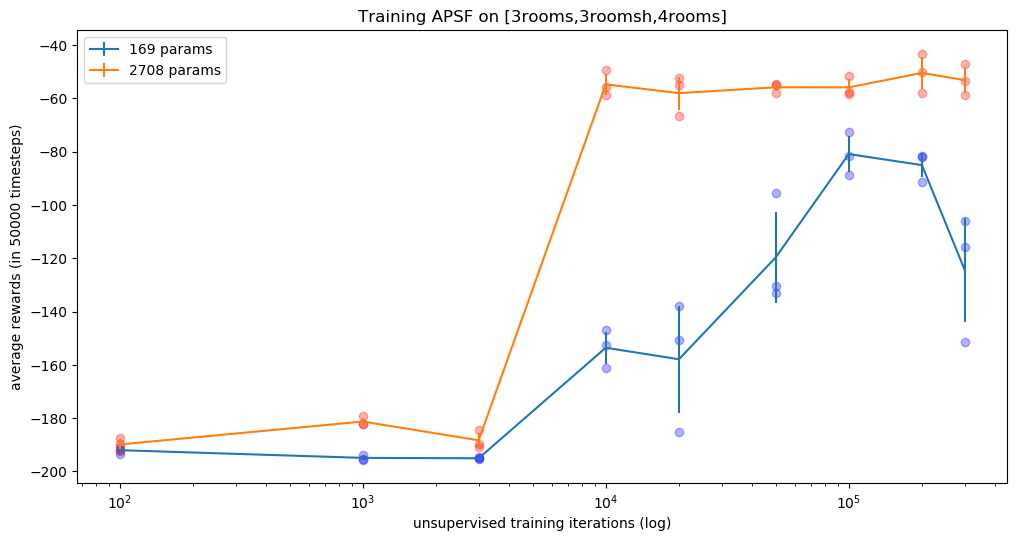

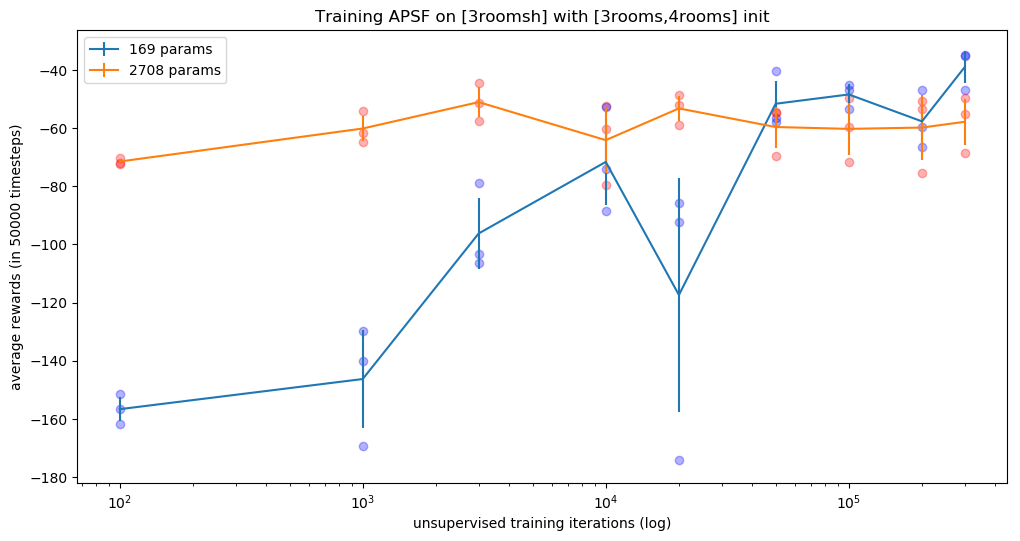

In [28]:
plot_performance(file_index='14', title='Training APSF on 4rooms')
plot_performance(file_index='30', title='Training APSF on 3roomsh')
plot_performance(file_index='27', title='Training APSF on [3rooms,3roomsh,4rooms]')
plot_performance(file_index='28', title='Training APSF on [3roomsh] with [3rooms,4rooms] init')

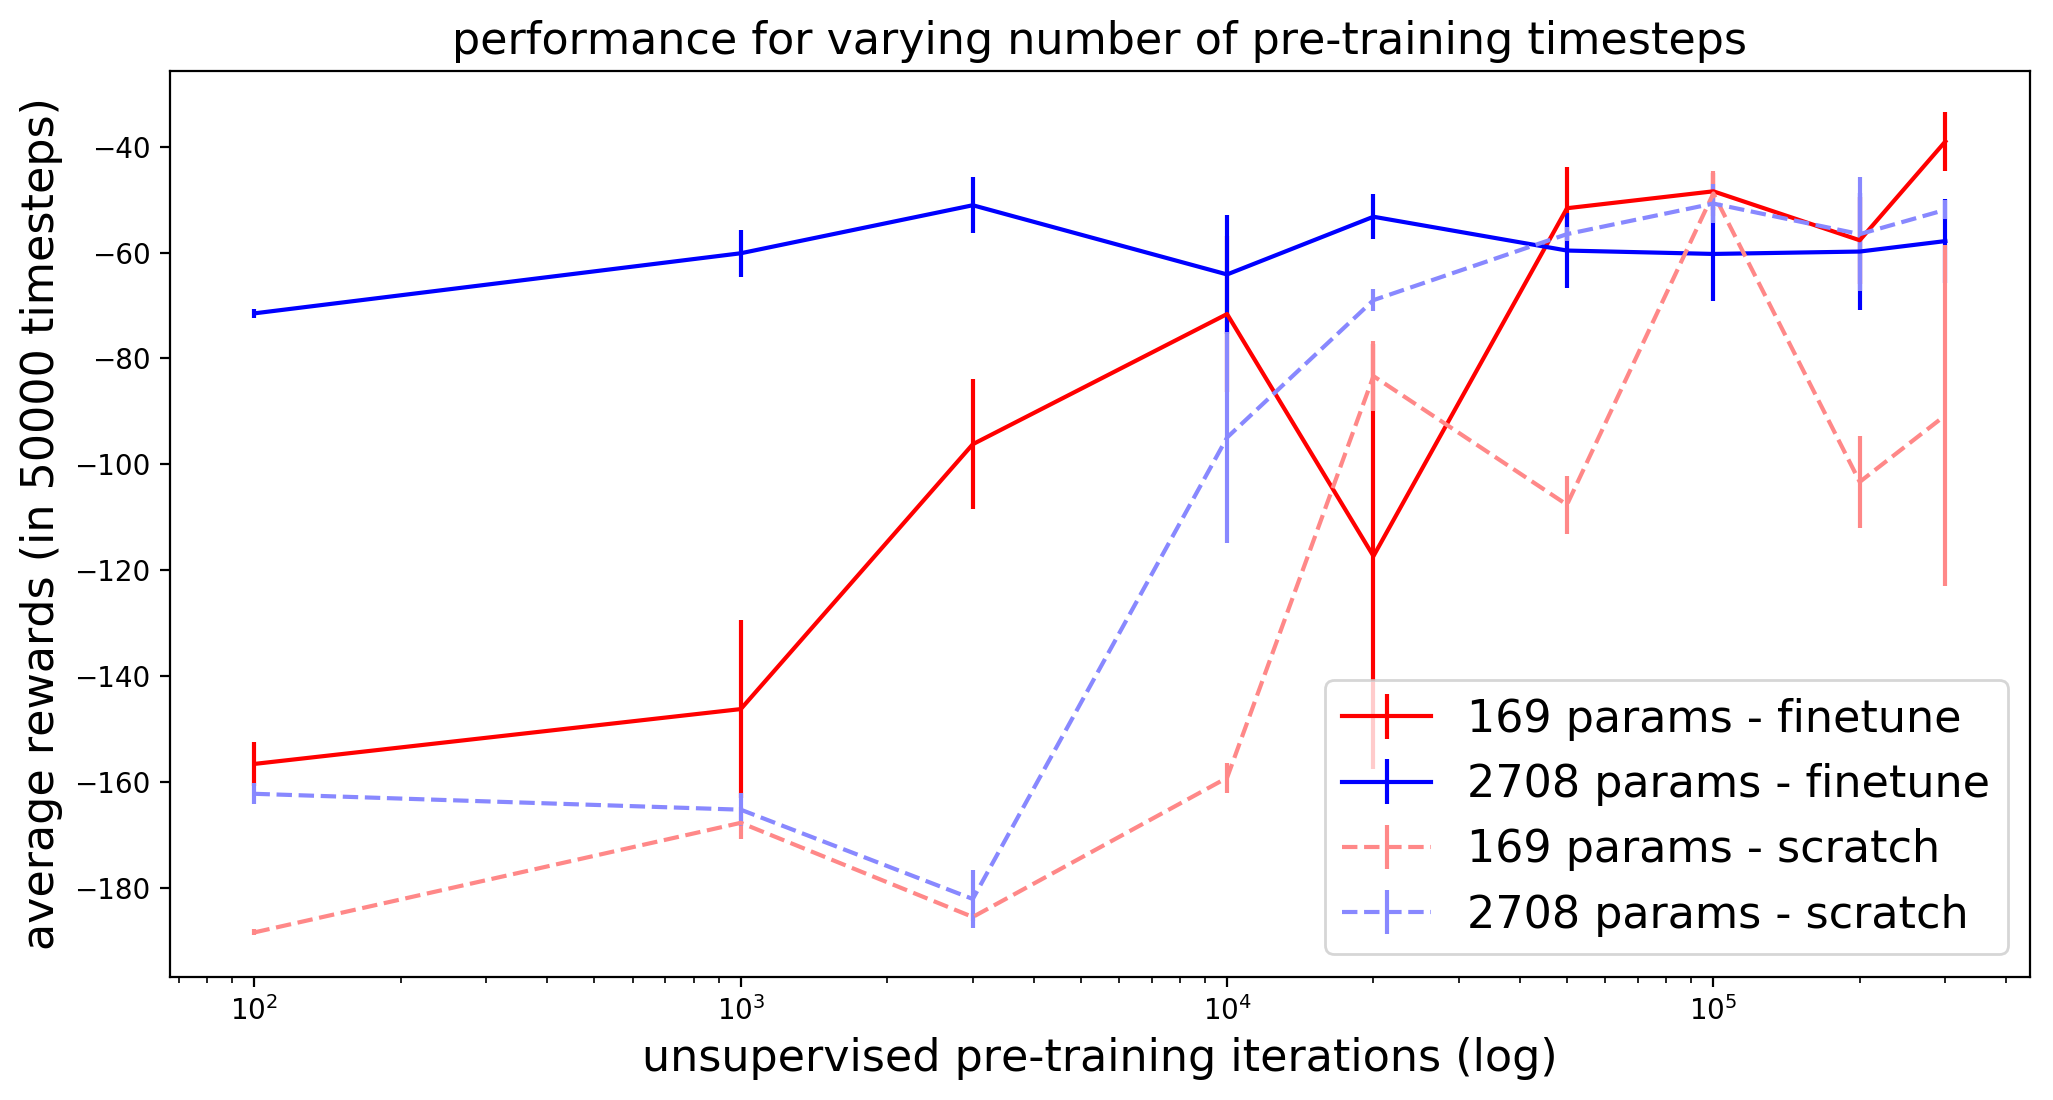

In [29]:
all_rewards = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
for i in iters:
    with open('../storage/30-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)

        for key, val in rewards.items():
            if('169' in key):
                all_rewards[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards[str(int(i))+'-2708'] = val
            else:
                raise
                
all_rewards2 = {}
iters = [1e2, 1e3, 3e3, 1e4, 2e4, 5e4, 1e5, 2e5, 3e5]
for i in iters:
    with open('../storage/28-'+str(int(i))+'-rewards-1eps.p', 'rb') as f:
        rewards = pickle.load(f)

        for key, val in rewards.items():
            if('169' in key):
                all_rewards2[str(int(i))+'-169'] = val
            elif('2708' in key):
                all_rewards2[str(int(i))+'-2708'] = val
            else:
                raise

plt.figure(figsize=(12,6),dpi=200)
clip = 50000
smooth = 1000
line1 = []
line1_std = []
line2 = []
line2_std = []
for j, (k, v) in enumerate(all_rewards2.items()):
    ind = k.split('-')
    r_vec = np.zeros((len(v[0]), 50000-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
        r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=1)
    std = np.std(mean)
    if(ind[1]=='169'):
        line1.append(mean)
        line1_std.append(std)
    if(ind[1]=='2708'):
        line2.append(mean)
        line2_std.append(std)

line1 = np.array(line1)
line2 = np.array(line2)
# import pdb;pdb.set_trace()
plt.errorbar(iters, np.mean(line1,axis=1), line1_std, c='#ff0000',label='169 params - finetune')
plt.errorbar(iters, np.mean(line2,axis=1), line2_std, c='#0000ff', label='2708 params - finetune')
# for i in range(line1.shape[1]):
#     plt.scatter(iters, line1[:,i], c='#ff0000', alpha=0.3)
#     plt.scatter(iters, line2[:,i], c='#0000ff', alpha=0.3)
    
line1 = []
line1_std = []
line2 = []
line2_std = []
for j, (k, v) in enumerate(all_rewards.items()):
    ind = k.split('-')
    r_vec = np.zeros((len(v[0]), 50000-smooth+1))
    for i, (t, r) in enumerate(zip(v[0], v[1])):
        r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)

    mean = np.mean(np.array(r_vec), axis=1)
    std = np.std(mean)
    if(ind[1]=='169'):
        line1.append(mean)
        line1_std.append(std)
    if(ind[1]=='2708'):
        line2.append(mean)
        line2_std.append(std)

line1 = np.array(line1)
line2 = np.array(line2)
# import pdb;pdb.set_trace()
plt.errorbar(iters, np.mean(line1,axis=1), line1_std, c='#ff8888',fmt='--', label='169 params - scratch')
plt.errorbar(iters, np.mean(line2,axis=1), line2_std, c='#8888ff',fmt='--',label='2708 params - scratch')
# for i in range(line1.shape[1]):
#     plt.scatter(iters, line1[:,i], c='#ff0000', alpha=0.3)
#     plt.scatter(iters, line2[:,i], c='#0000ff', alpha=0.3)

plt.xscale('log')
plt.xlabel('unsupervised pre-training iterations (log)', fontsize=16)
plt.ylabel('average rewards (in 50000 timesteps)', fontsize=16)
plt.title('performance for varying number of pre-training timesteps', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.savefig("../storage/fig5.13-h.png")
plt.show()